# Detecting Anomalies using Heterogeneous GNNs

## Exploring the CIDDS-001 dataset

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The following download can be extremely slow. It is safer to perform it outside of this notebook.

In [4]:
# from io import BytesIO
# from urllib.request import urlopen
# from zipfile import ZipFile

# url = 'https://www.hs-coburg.de/fileadmin/hscoburg/WISENT-CIDDS-001.zip'
# with urlopen(url) as zurl:
#     with ZipFile(BytesIO(zurl.read())) as zfile:
#         zfile.extractall('.')

In [5]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
import torch

In [6]:
df = pd.read_csv("CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv")
df

C:\Users\Xu Wen Tao\AppData\Local\Temp\ipykernel_13608\1465322410.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv")


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,62605,EXT_SERVER,8082.0,2,319,1,.AP...,0,normal,---,---,---
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,443,192.168.210.5,51433.0,1,54,1,.A....,32,normal,---,---,---
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,51433,10179_174,443.0,1,55,1,.A....,0,normal,---,---,---
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,445,192.168.220.6,56281.0,1,108,1,.AP...,0,normal,---,---,---


In [8]:
df = df.drop(columns=['Src Pt', 'Dst Pt', 'Flows', 'Tos', 'class', 'attackID', 'attackDescription'])
df['attackType'] = df['attackType'].replace('---', 'benign')
df['Date first seen'] = pd.to_datetime(df['Date first seen'])
df

KeyError: "['Src Pt', 'Dst Pt', 'Flows', 'Tos', 'class', 'attackID', 'attackDescription'] not found in axis"

In [12]:
df = df.sample(10000, random_state=2023)

benign        83.55
dos           14.32
portScan       2.07
pingScan       0.05
bruteForce     0.01
Name: attackType, dtype: float64


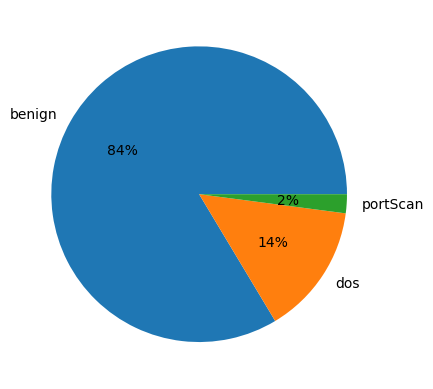

In [13]:
count_labels = df['attackType'].value_counts() / len(df) * 100
print(count_labels)
plt.pie(count_labels[:3], labels=df['attackType'].unique()[:3], autopct='%.0f%%')
plt.show()

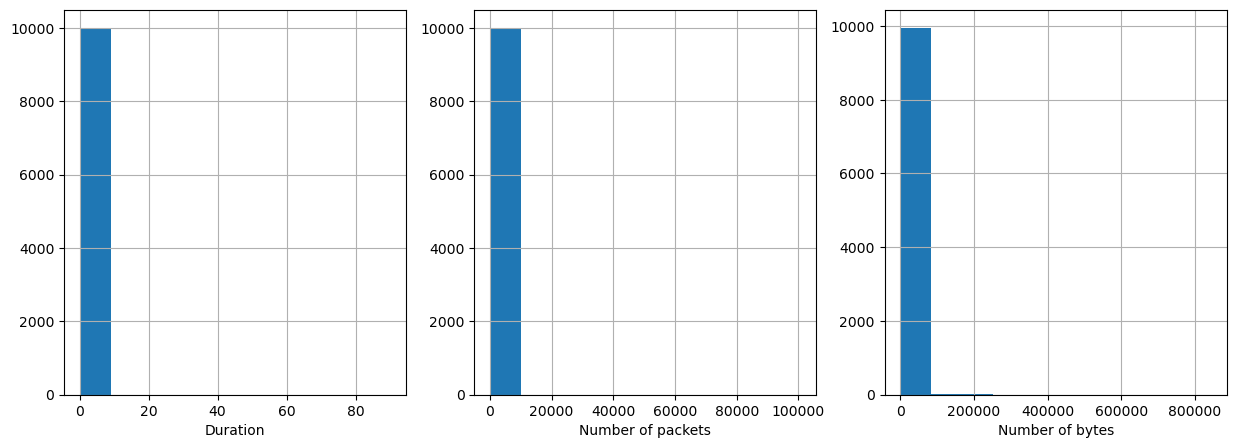

In [14]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
pd.to_numeric(df['Bytes'], errors='coerce').hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

## Preprocessing the CIDDS-001 dataset

In [15]:
df['weekday'] = df['Date first seen'].dt.weekday
df = pd.get_dummies(df, columns=['weekday']).rename(columns = {'weekday_0': 'Monday',
                                                              'weekday_1': 'Tuesday',
                                                              'weekday_2': 'Wednesday',
                                                              'weekday_3': 'Thursday',
                                                              'weekday_4': 'Friday',
                                                              'weekday_5': 'Saturday',
                                                              'weekday_6': 'Sunday',
                                                             })

df['daytime'] = (df['Date first seen'].dt.second +df['Date first seen'].dt.minute*60 + df['Date first seen'].dt.hour*60*60)/(24*60*60)

In [16]:
def one_hot_flags(input):
    return [1 if char1 == char2 else 0 for char1, char2 in zip('APRSF', input[1:])]

df = df.reset_index(drop=True)
ohe_flags = one_hot_flags(df['Flags'].to_numpy())
ohe_flags = df['Flags'].apply(one_hot_flags).to_list()
df[['ACK', 'PSH', 'RST', 'SYN', 'FIN']] = pd.DataFrame(ohe_flags, columns=['ACK', 'PSH', 'RST', 'SYN', 'FIN'])
df = df.drop(columns=['Date first seen', 'Flags'])
df

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,ACK,PSH,RST,SYN,FIN
0,0.000,TCP,192.168.220.16,10979_53,1,54,benign,0,0,0,0,1,0,0,0.632870,0,0,0,0,1,0,0,1,0,0,0,1
1,0.004,UDP,DNS,192.168.220.6,2,369,benign,0,0,0,0,1,0,0,0.509155,0,0,0,0,1,0,0,0,0,0,0,0
2,0.119,TCP,192.168.220.7,10555_22,2,140,benign,0,0,1,0,0,0,0,0.333900,0,0,1,0,0,0,0,1,0,0,1,0
3,0.251,TCP,192.168.210.5,10527_14,3,220,benign,0,0,0,1,0,0,0,0.001632,0,0,0,1,0,0,0,1,1,0,0,0
4,0.000,TCP,10926_27,192.168.220.7,1,66,benign,0,0,1,0,0,0,0,0.773090,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000,TCP,192.168.220.6,11235_76,1,66,benign,0,0,0,1,0,0,0,0.554363,0,0,0,1,0,0,0,1,0,0,0,0
9996,0.017,TCP,192.168.220.16,14252_80,3,229,benign,0,1,0,0,0,0,0,0.431771,0,1,0,0,0,0,0,1,1,0,0,1
9997,0.000,UDP,DNS,192.168.210.5,1,289,benign,0,1,0,0,0,0,0,0.463056,0,1,0,0,0,0,0,0,0,0,0,0
9998,0.000,TCP,10107_39,192.168.220.4,1,74,benign,0,0,0,1,0,0,0,0.427350,0,0,0,1,0,0,0,1,0,0,1,0


In [19]:
df['Src IP Addr'].value_counts()

192.168.220.16    1286
192.168.100.6      715
DNS                575
192.168.210.5      418
192.168.220.4      367
                  ... 
10056_71             1
10056_141            1
10092_100            1
13940_56             1
10162_65             1
Name: Src IP Addr, Length: 1351, dtype: int64

In [20]:
temp = pd.DataFrame()
temp['SrcIP'] = df['Src IP Addr'].astype(str)
temp['SrcIP'][~temp['SrcIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['SrcIP'].str.split('.', expand=True).rename(columns = {2: 'ipsrc3', 3: 'ipsrc4'}).astype(int)[['ipsrc3', 'ipsrc4']]
temp['ipsrc'] = temp['ipsrc3'].apply(lambda x: format(x, "b").zfill(8)) + temp['ipsrc4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipsrc'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipsrc_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16
0,0.000,TCP,192.168.220.16,10979_53,1,54,benign,0,0,0,0,1,0,0,0.632870,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
1,0.004,UDP,DNS,192.168.220.6,2,369,benign,0,0,0,0,1,0,0,0.509155,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.119,TCP,192.168.220.7,10555_22,2,140,benign,0,0,1,0,0,0,0,0.333900,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1
3,0.251,TCP,192.168.210.5,10527_14,3,220,benign,0,0,0,1,0,0,0,0.001632,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1
4,0.000,TCP,10926_27,192.168.220.7,1,66,benign,0,0,1,0,0,0,0,0.773090,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
temp = pd.DataFrame()
temp['DstIP'] = df['Dst IP Addr'].astype(str)
temp['DstIP'][~temp['DstIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['DstIP'].str.split('.', expand=True).rename(columns = {2: 'ipdst3', 3: 'ipdst4'}).astype(int)[['ipdst3', 'ipdst4']]
temp['ipdst'] = temp['ipdst3'].apply(lambda x: format(x, "b").zfill(8)) \
                + temp['ipdst4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipdst'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipdst_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16
0,0.000,TCP,192.168.220.16,10979_53,1,54,benign,0,0,0,0,1,0,0,0.632870,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.004,UDP,DNS,192.168.220.6,2,369,benign,0,0,0,0,1,0,0,0.509155,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0
2,0.119,TCP,192.168.220.7,10555_22,2,140,benign,0,0,1,0,0,0,0,0.333900,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.251,TCP,192.168.210.5,10527_14,3,220,benign,0,0,0,1,0,0,0,0.001632,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.000,TCP,10926_27,192.168.220.7,1,66,benign,0,0,1,0,0,0,0,0.773090,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1


In [23]:
m_index = df[pd.to_numeric(df['Bytes'], errors='coerce').isnull() == True].index
df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
df['Bytes'] = pd.to_numeric(df['Bytes'], errors='coerce', downcast='integer')

C:\Users\Xu Wen Tao\AppData\Local\Temp\ipykernel_13608\2402852410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))


In [24]:
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Proto', 'attackType'])
df.head(5)

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
0,0.000,192.168.220.16,10979_53,1,54,0,0,0,0,1,0,0,0.632870,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0.004,DNS,192.168.220.6,2,369,0,0,0,0,1,0,0,0.509155,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0
2,0.119,192.168.220.7,10555_22,2,140,0,0,1,0,0,0,0,0.333900,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0.251,192.168.210.5,10527_14,3,220,0,0,0,1,0,0,0,0.001632,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0.000,10926_27,192.168.220.7,1,66,0,0,1,0,0,0,0,0.773090,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0


In [28]:
# labels = ['benign', 'bruteForce', 'dos', 'pingScan', 'portScan']
labels = ['benign', 'dos']

df_train, df_test = train_test_split(df, random_state=0, test_size=0.2, stratify=df[labels])
df_val, df_test = train_test_split(df_test, random_state=0, test_size=0.5, stratify=df_test[labels])

In [29]:
scaler = PowerTransformer()
df_train[['Duration', 'Packets', 'Bytes']] = scaler.fit_transform(df_train[['Duration', 'Packets', 'Bytes']])
df_val[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_val[['Duration', 'Packets', 'Bytes']])
df_test[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_test[['Duration', 'Packets', 'Bytes']])

In [30]:
df_train[df_train['benign'] == 1]

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
473,2.014332,10199_2,192.168.220.4,1.741170,1.511097,1,0,0,0,0,0,0,0.422975,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2243,-0.590244,10143_80,192.168.220.11,-0.994392,-1.325521,0,1,0,0,0,0,0,0.453264,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0
7909,-0.523305,192.168.200.5,192.168.100.5,0.108221,0.132759,0,0,0,1,0,0,0,0.423252,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0
3749,-0.590244,192.168.220.11,11294_119,-0.994392,-1.019759,0,0,0,1,0,0,0,0.412130,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
301,-0.590244,10223_4,192.168.200.8,-0.994392,-1.325521,0,0,0,0,0,0,1,0.424676,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,2.353306,192.168.220.11,11479_15,1.530978,1.591980,0,1,0,0,0,0,0,0.624630,0,1,0,0,0,0,0,1,1,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4378,-0.523305,192.168.220.15,DNS,0.108221,0.013258,0,0,1,0,0,0,0,0.553519,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8553,0.238714,10150_12,192.168.200.8,0.650008,0.229209,0,0,0,1,0,0,0,0.491528,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
9242,-0.590244,192.168.200.4,10621_107,-0.994392,-1.019759,0,1,0,0,0,0,0,0.491053,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


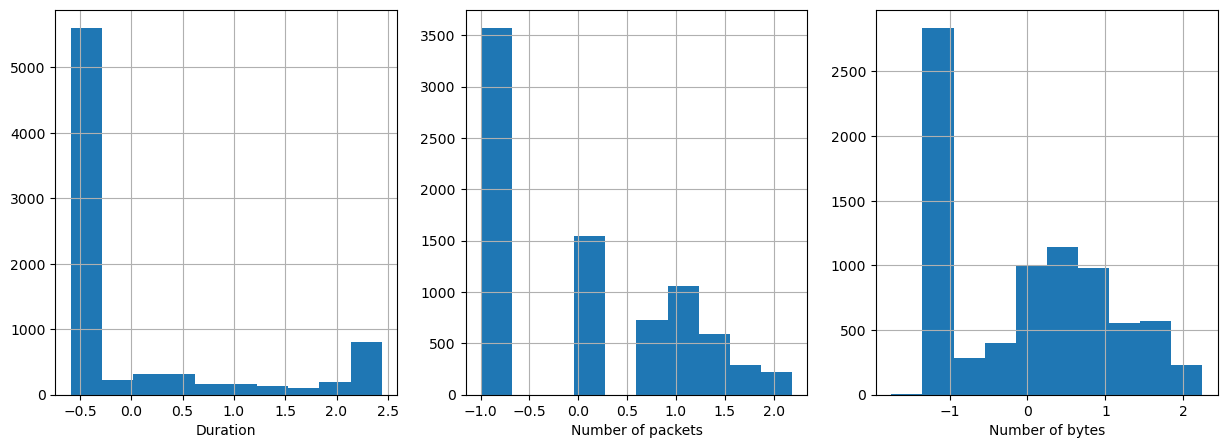

In [31]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df_train['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df_train['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
df_train['Bytes'].hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

## Implementing a heterogeneous GNN

In [99]:
features_host = [f'ipsrc_{i}' for i in range(1, 17)] + [f'ipdst_{i}' for i in range(1, 17)]
features_flow = ['daytime', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Duration', 'Packets', 'Bytes', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 'ICMP ']

In [100]:
print(features_host)
print()
print(features_flow)

['ipsrc_1', 'ipsrc_2', 'ipsrc_3', 'ipsrc_4', 'ipsrc_5', 'ipsrc_6', 'ipsrc_7', 'ipsrc_8', 'ipsrc_9', 'ipsrc_10', 'ipsrc_11', 'ipsrc_12', 'ipsrc_13', 'ipsrc_14', 'ipsrc_15', 'ipsrc_16', 'ipdst_1', 'ipdst_2', 'ipdst_3', 'ipdst_4', 'ipdst_5', 'ipdst_6', 'ipdst_7', 'ipdst_8', 'ipdst_9', 'ipdst_10', 'ipdst_11', 'ipdst_12', 'ipdst_13', 'ipdst_14', 'ipdst_15', 'ipdst_16']

['daytime', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Duration', 'Packets', 'Bytes', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 'ICMP ']


In [101]:
def get_connections(ip_map, src_ip, dst_ip):
    src1 = [ip_map[ip] for ip in src_ip]
    src2 = [ip_map[ip] for ip in dst_ip]
    src = np.column_stack((src1, src2)).flatten()
    dst = list(range(len(src_ip)))
    dst = np.column_stack((dst, dst)).flatten()
    return torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()

In [102]:
subgraph = df_train.head(10)
subgraph

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
5712,-0.556571,192.168.100.6,192.168.220.16,0.970971,0.518451,0,0,0,0,1,0,0,0.595845,0,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
473,2.014332,10199_2,192.168.220.4,1.741170,1.511097,1,0,0,0,0,0,0,0.422975,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2243,-0.590244,10143_80,192.168.220.11,-0.994392,-1.325521,0,1,0,0,0,0,0,0.453264,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0
7909,-0.523305,192.168.200.5,192.168.100.5,0.108221,0.132759,0,0,0,1,0,0,0,0.423252,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0
3749,-0.590244,192.168.220.11,11294_119,-0.994392,-1.019759,0,0,0,1,0,0,0,0.412130,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
301,-0.590244,10223_4,192.168.200.8,-0.994392,-1.325521,0,0,0,0,0,0,1,0.424676,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
138,-0.590244,192.168.220.7,10798_7,0.108221,0.935011,0,0,0,1,0,0,0,0.752245,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1510,-0.590244,192.168.200.8,10068_42,-0.994392,-1.296456,0,1,0,0,0,0,0,0.389560,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1945,-0.490441,192.168.220.16,192.168.100.6,1.182805,0.908134,0,0,0,0,1,0,0,0.546829,0,0,0,0,1,0,0,1,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
6146,0.972342,192.168.220.4,10199_10,2.149568,1.920933,0,1,0,0,0,0,0,0.311030,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [103]:
# subgraph = df_train.head(10)
src_ip = subgraph['Src IP Addr'].to_numpy()
dst_ip = subgraph['Dst IP Addr'].to_numpy()

In [104]:
src_ip

array(['192.168.100.6', '10199_2', '10143_80', '192.168.200.5',
       '192.168.220.11', '10223_4', '192.168.220.7', '192.168.200.8',
       '192.168.220.16', '192.168.220.4'], dtype=object)

In [105]:
ip_map = {ip:index for index, ip in enumerate(np.unique(np.append(src_ip, dst_ip)))}
src1 = [ip_map[ip] for ip in src_ip]
src2 = [ip_map[ip] for ip in dst_ip]
src = np.column_stack((src1, src2)).flatten()
dst = list(range(len(src_ip)))
dst = np.column_stack((dst, dst)).flatten()

torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()

host_to_flow, flow_to_host = get_connections(ip_map, src_ip, dst_ip)

In [106]:
src1

[8, 3, 1, 9, 11, 4, 14, 10, 12, 13]

In [107]:
src2

[12, 13, 11, 7, 6, 10, 5, 0, 8, 2]

In [108]:
src

array([ 8, 12,  3, 13,  1, 11,  9,  7, 11,  6,  4, 10, 14,  5, 10,  0, 12,
        8, 13,  2])

In [109]:
dst

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

In [110]:
ip_map

{'10068_42': 0,
 '10143_80': 1,
 '10199_10': 2,
 '10199_2': 3,
 '10223_4': 4,
 '10798_7': 5,
 '11294_119': 6,
 '192.168.100.5': 7,
 '192.168.100.6': 8,
 '192.168.200.5': 9,
 '192.168.200.8': 10,
 '192.168.220.11': 11,
 '192.168.220.16': 12,
 '192.168.220.4': 13,
 '192.168.220.7': 14}

In [111]:
host_to_flow

tensor([[ 8, 12,  3, 13,  1, 11,  9,  7, 11,  6,  4, 10, 14,  5, 10,  0, 12,  8,
         13,  2],
        [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9]], dtype=torch.int32)

In [112]:
flow_to_host

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9],
        [ 8, 12,  3, 13,  1, 11,  9,  7, 11,  6,  4, 10, 14,  5, 10,  0, 12,  8,
         13,  2]], dtype=torch.int32)

'flow' means edge

In [113]:
batch = HeteroData()
batch['host'].x = torch.Tensor(subgraph[features_host].to_numpy()).float()
batch['flow'].x = torch.Tensor(subgraph[features_flow].to_numpy()).float()
batch['flow'].y = torch.Tensor(subgraph[labels].to_numpy()).float()
batch['host','flow'].edge_index = host_to_flow
batch['flow','host'].edge_index = flow_to_host

In [118]:
batch['host'].x.size()

torch.Size([10, 32])

In [119]:
len(features_host)

32

In [127]:
batch['flow'].y

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [125]:
batch['host','flow']

{'edge_index': tensor([[ 8, 12,  3, 13,  1, 11,  9,  7, 11,  6,  4, 10, 14,  5, 10,  0, 12,  8,
         13,  2],
        [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9]], dtype=torch.int32)}

In [124]:
batch['host','flow'].edge_index.size()

torch.Size([2, 20])

In [126]:
batch['host','flow'].edge_index

tensor([[ 8, 12,  3, 13,  1, 11,  9,  7, 11,  6,  4, 10, 14,  5, 10,  0, 12,  8,
         13,  2],
        [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9]], dtype=torch.int32)

In [140]:
batch.x_dict['host'].size()

torch.Size([3840, 32])

In [141]:
batch.x_dict['flow'].size()

torch.Size([3840, 20])

In [136]:
batch.x_dict

{'host': tensor([[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 0.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'flow': tensor([[0.4128, 1.0000, 1.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.7386, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5704, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         ...,
         [0.5949, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.0000],
         [0.5609, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         [0.7019, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]])}

In [142]:
batch.edge_index_dict[('host', 'to', 'flow')].size()

torch.Size([2, 7680])

In [137]:
batch.edge_index_dict

{('host',
  'to',
  'flow'): tensor([[ 151,  100,  163,  ..., 3750, 3652, 3750],
         [   0,    0,    1,  ..., 3838, 3839, 3839]]),
 ('flow',
  'to',
  'host'): tensor([[   0,    0,    1,  ..., 3838, 3839, 3839],
         [ 151,  100,  163,  ..., 3750, 3652, 3750]])}

In [41]:
df['Src IP Addr'].value_counts()

192.168.220.16    1286
192.168.100.6      715
DNS                575
192.168.210.5      418
192.168.220.4      367
                  ... 
10056_71             1
10056_141            1
10092_100            1
13940_56             1
10162_65             1
Name: Src IP Addr, Length: 1351, dtype: int64

In [128]:
df_train.shape

(8000, 65)

In [129]:
df_val.shape

(1000, 65)

In [130]:

def create_dataloader(df, subgraph_size=256):
    data = []
    n_subgraphs = len(df) // subgraph_size
    for i in range(1, n_subgraphs+1):
        subgraph = df[(i-1)*subgraph_size:i*subgraph_size]
        src_ip = subgraph['Src IP Addr'].to_numpy()
        dst_ip = subgraph['Dst IP Addr'].to_numpy()
        
        ip_map = {ip:index for index, ip in enumerate(np.unique(np.append(src_ip, dst_ip)))}
        host_to_flow, flow_to_host = get_connections(ip_map, src_ip, dst_ip)

        batch = HeteroData()
        batch['host'].x = torch.Tensor(subgraph[features_host].to_numpy()).float()
        batch['flow'].x = torch.Tensor(subgraph[features_flow].to_numpy()).float()
        batch['flow'].y = torch.Tensor(subgraph[labels].to_numpy()).float()
        batch['host','flow'].edge_index = host_to_flow
        batch['flow','host'].edge_index = flow_to_host
        data.append(batch)

    return DataLoader(data, batch_size=BATCH_SIZE)

train_loader = create_dataloader(df_train)
val_loader = create_dataloader(df_val)
test_loader = create_dataloader(df_test)

In [133]:
from torch_geometric.nn import Linear, HeteroConv, SAGEConv, GATConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, dim_h, dim_out, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('host', 'to', 'flow'): SAGEConv((-1,-1), dim_h, add_self_loops=False),
                ('flow', 'to', 'host'): SAGEConv((-1,-1), dim_h, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['flow'])

In [135]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN(dim_h=64, dim_out=2, num_layers=3).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = []
    y_true = []
    n_subgraphs = 0
    total_loss = 0

    for batch in loader:
        batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out, batch['flow'].y.float())
        y_pred.append(out.argmax(dim=1))
        y_true.append(batch['flow'].y.argmax(dim=1))
        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE
        
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true).cpu()
    f1score = f1_score(y_true, y_pred, average='macro')

    return total_loss/n_subgraphs, f1score, y_pred, y_true


model.train()
for epoch in range(101):
    n_subgraphs = 0
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out, batch['flow'].y.float())
        loss.backward()
        optimizer.step()

        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE

    if epoch % 10 == 0:
        val_loss, f1score, _, _ = test(val_loader)
        print(f'Epoch {epoch} | Loss: {total_loss/n_subgraphs:.4f} | Val loss: {val_loss:.4f} | Val F1-score: {f1score:.4f}')

Epoch 0 | Loss: 0.6527 | Val loss: 0.6126 | Val F1-score: 0.4614
Epoch 10 | Loss: 0.2802 | Val loss: 0.2605 | Val F1-score: 0.4614
Epoch 20 | Loss: 0.0446 | Val loss: 0.0342 | Val F1-score: 1.0000
Epoch 30 | Loss: 0.0053 | Val loss: 0.0027 | Val F1-score: 1.0000
Epoch 40 | Loss: 0.0020 | Val loss: 0.0008 | Val F1-score: 1.0000
Epoch 50 | Loss: 0.0011 | Val loss: 0.0004 | Val F1-score: 1.0000
Epoch 60 | Loss: 0.0006 | Val loss: 0.0002 | Val F1-score: 1.0000
Epoch 70 | Loss: 0.0004 | Val loss: 0.0002 | Val F1-score: 1.0000
Epoch 80 | Loss: 0.0002 | Val loss: 0.0001 | Val F1-score: 1.0000
Epoch 90 | Loss: 0.0002 | Val loss: 0.0001 | Val F1-score: 1.0000
Epoch 100 | Loss: 0.0001 | Val loss: 0.0001 | Val F1-score: 1.0000


In [143]:
_, _, y_pred, y_true = test(test_loader)

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      benign     1.0000    1.0000    1.0000       662
         dos     1.0000    1.0000    1.0000       106

    accuracy                         1.0000       768
   macro avg     1.0000    1.0000    1.0000       768
weighted avg     1.0000    1.0000    1.0000       768



In [147]:
df_test[labels].value_counts()

benign  dos
1       0      835
0       1      143
        0       22
dtype: int64

ValueError: 'label' must be of length 'x'

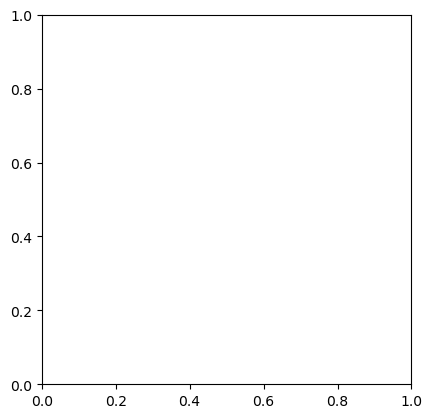

In [144]:
df_pred = pd.DataFrame([y_pred.numpy(), y_true.numpy()]).T
df_pred.columns = ['pred', 'true']
plt.pie(df_pred['true'][df_pred['pred'] != df_pred['true']].value_counts(), labels=labels, autopct='%.0f%%')

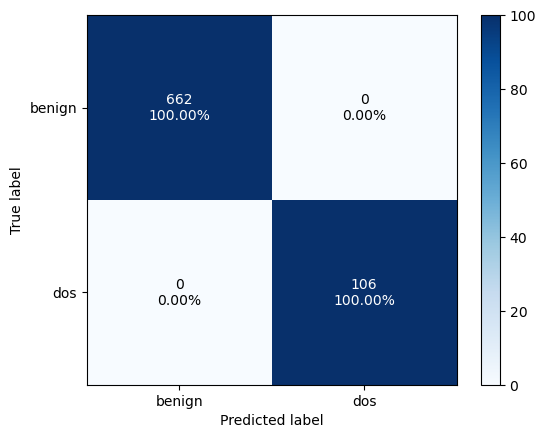

In [148]:
matrix = confusion_matrix(y_true, y_pred)
norm_matrix = matrix / matrix.sum(axis=1) * 100

plt.imshow(norm_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
    
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    text = f"{matrix[i,j]:,}\n{norm_matrix[i,j]:.2f}%"
    plt.text(j, i, text,
            horizontalalignment='center', verticalalignment='center',
            color='white' if matrix[i,j] >= matrix[i,:].mean() else 'black')
plt.show()